In [0]:
for o,u in enumerate(os.scandir(path_)):
  print(type(u.name))  

In [0]:
path_ = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/input'
save_dst = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/Resolution_input/'
no_files = len(os.listdir(path_))
two = round(no_files*0.2)

for o,u in enumerate(os.scandir(path_)):
    if os.path.isfile(u.path):
      if o<=two:
        img = Image.open(u.path)
        image_ = img.resize((130,130))
        image1 = image_.resize((256,256),Image.NEAREST)
        image1.save(save_dst+u.name)           

      if o>two:
        img = Image.open(u.path)
        image_ = img.resize((130,130))
        image1 = image_.resize((256,256),Image.BILINEAR)
        image1.save(save_dst+u.name)          

# '''one of :py:attr:`PIL.Image.NEAREST`, :py:attr:`PIL.Image.BOX`,  
#    :py:attr:`PIL.Image.BILINEAR`, :py:attr:`PIL.Image.HAMMING`,  
#    :py:attr:`PIL.Image.BICUBIC` or :py:attr:`PIL.Image.LANCZOS`.  
#    Default filter is :py:attr:`PIL.Image.BICUBIC`.'''
              

In [0]:
bs = 16

label = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/input/'
label_func = lambda x : label + (x.name)

IL = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/Resolution_input')
LL = IL.split_by_rand_pct(valid_pct=0.2).label_from_func(label_func)
data = LL.transform(get_transforms(max_lighting=None,max_warp=None),tfm_y = True).databunch(bs=bs).normalize(imagenet_stats,do_y=True)


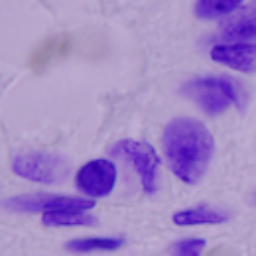

In [0]:
data.train_ds.x[277]

In [0]:
import fastai                                   
import torch                                  
from fastai import *                          
from fastai.vision import *                 
from fastai.callbacks import *               
from fastai.utils.mem import *               
from torchvision.models import vgg16_bn 

arch = models.resnet34

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          


base_loss = F.l1_loss


vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)


blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])


In [0]:
wd = 1e-03

learn = unet_learner(data=data,arch = arch,wd=wd,loss_func=feat_loss,
             blur=True,norm_type=NormType.Weight)

gc.collect();

epoch,train_loss,valid_loss,time
0,5.591869,#na#,00:38
1,4.376659,#na#,00:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


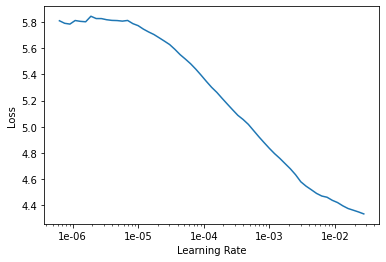

In [0]:
learn.lr_find()        
learn.recorder.plot()   

In [0]:
lr = 6e-04

In [0]:
def Do_fit(save_name,lr):
  learn.fit_one_cycle(15,lr,pct_start=0.7)
  learn.save(save_name)
  learn.show_results(rows=1,imgsize=5)

epoch,train_loss,valid_loss,time
0,3.428070,2.788710,00:36
1,2.524773,1.956740,00:36
2,2.085749,1.834018,00:35
3,1.963295,1.764334,00:35
4,1.742275,1.936985,00:35
5,1.668742,2.143442,00:35
6,1.632908,1.406580,00:35
7,1.419906,1.244869,00:35
8,1.141442,1.014170,00:35
9,0.923395,1.010677,00:35


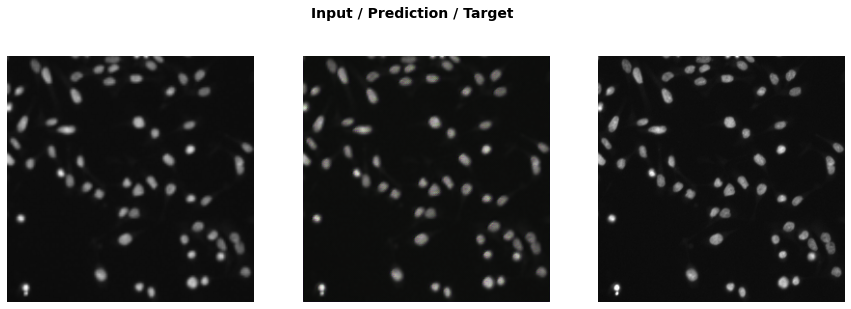

In [0]:
Do_fit('freeze_cell',slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.670913,0.998206,00:36
1,0.665247,0.987508,00:36
2,0.655319,0.981727,00:36
3,0.649754,0.923967,00:36
4,0.622676,0.992075,00:36
5,0.586258,0.856516,00:36
6,0.555448,0.854401,00:36
7,0.536886,0.836505,00:36
8,0.511407,0.908207,00:36
9,0.505978,0.871245,00:36


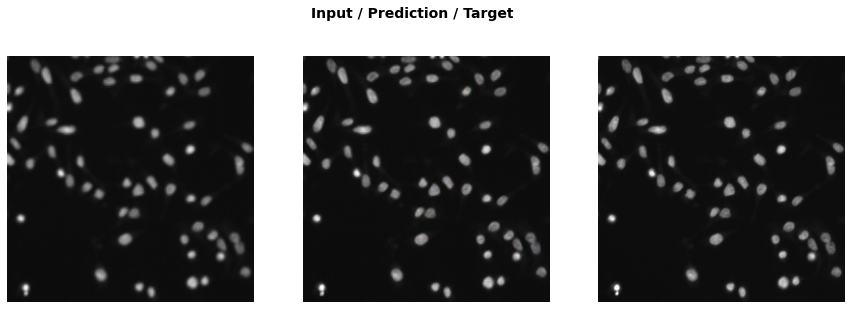

In [0]:
Do_fit('unfreeze_cell',slice(lr/10,lr))  

In [0]:
# learn.export('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/cell_model.hdf5')

In [0]:
learn = load_learner('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/','model.hdf5')

In [0]:
g = 337
# os.mkdir('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/Showcase/cell_tracking')

In [0]:
q,w,e = learn.predict(ui)
q.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/showcase/prediction.jpg')

In [0]:
ui = open_image(f'/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/input_{g}.jpg')
ui
ui.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/showcase/input.jpg')

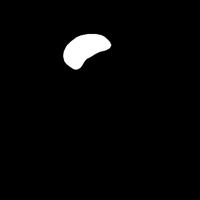

In [135]:
ti = open_image(f'/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/target/target_{g}.jpg')
ti.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/showcase/original.jpg')
ti 

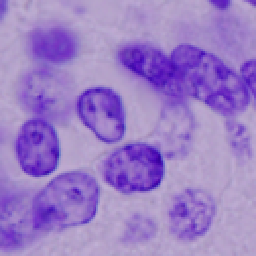

In [78]:
from PIL import Image
img = Image.open('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/test/Complete_intestinal_metaplasia_in_a_case_of_chronic_gastritis,_PAS.jpg')

ui

In [0]:
image = img.resize((256,256),Image.ANTIALIAS)

In [0]:
image.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/test/original.jpg')

In [0]:
small = image.resize((130,130))
back_up = small.resize((256,256),Image.NEAREST)

In [0]:
back_up.save('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/test/crappy_less.jpg')